In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

In [3]:
from lint_analysis.bin_counts import cache

In [4]:
tokens = cache.token_counts(10000)

In [5]:
import re

from collections import OrderedDict

tokens = OrderedDict([
    (t, c) for t, c in tokens.items()
    if not re.match('^[0-9ivx.]+$', t)
])

In [6]:
data = []

for i, (token, count) in enumerate(tokens.items()):
    
    series = cache.token_series(token)
    exp_var = series.sum() * (1/100) * (1 - 1/100)
    
    data.append((count, series.var(), exp_var))
    
    if i % 1000 == 0: print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [7]:
import pandas as pd

df = pd.DataFrame(
    data,
    columns=('count', 'var', 'exp'),
    index=tokens.keys(),
)

In [8]:
import math

df['score'] = df.index.map(
    lambda t: df.loc[t]['var'] / df.loc[t]['exp']
)

In [9]:
from pyemd import emd

In [10]:
def make_distance_matrix(dim, cost=1):
    
    d = np.zeros((dim, dim))
    
    for i in range(dim):
        for j in range(dim):
            d[i][j] = abs(i-j)*cost
            
    return d

In [11]:
dm = make_distance_matrix(100)

def series_emd(s1, s2):
    return emd(s1, s2, dm)

In [12]:
def token_emd(t1, t2):
    
    s1 = cache.token_series(t1)
    s2 = cache.token_series(t2)
    
    return series_emd(s1/s1.sum(), s2/s2.sum())

In [14]:
token_emd('girls', 'death')

8.97400245802501

In [16]:
top = df.sort_values('score', ascending=False).head(500)

In [17]:
import random

shuffled = list(top.index)
random.shuffle(shuffled)

In [18]:
series = {
    token: cache.token_series(token)
    for token in top.index
}

In [19]:
from itertools import combinations
from scipy.spatial import distance

In [21]:
d = []
for i, (t1, t2) in enumerate(combinations(shuffled, 2)):
    
    s1 = series[t1]
    s2 = series[t2]
    
    d.append(series_emd(s1/s1.sum(), s2/s2.sum()))
    if i%1000 == 0: print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000


In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram

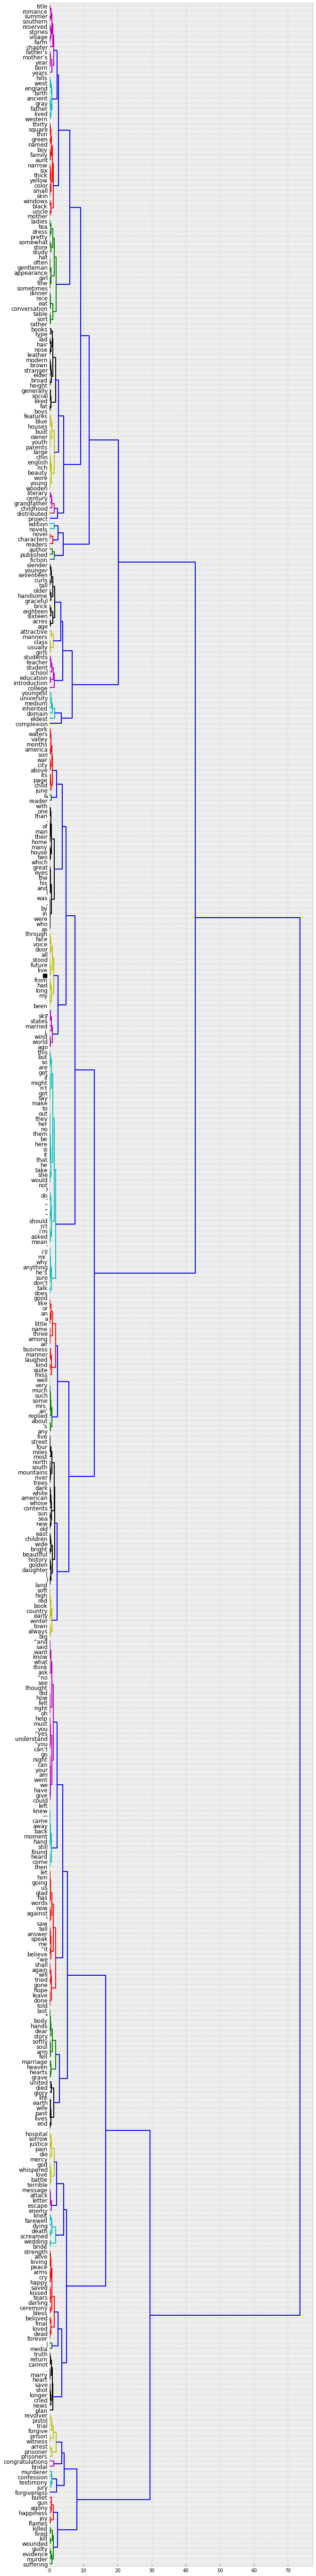

In [25]:
link = linkage(d, method='ward')

plt.figure(figsize=(10, 100))

dendrogram(
    link,
    labels=shuffled,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=12,
    color_threshold=2,
)

plt.show()

In [26]:
from scipy.cluster.hierarchy import fcluster

In [27]:
import math

from scipy.ndimage.measurements import center_of_mass
from itertools import cycle
    
class Cohorts(dict):
        
    def add(self, key, label, tokens):
        
        if type(tokens) is str:
            tokens = list(map(str.strip, token_str.strip().splitlines()))

        self[key] = (label, tokens)
        
    def density(self, key):
        _, tokens = self[key]
        counts = np.array([cache.token_series(token) for token in tokens]).sum(0)
        return counts / counts.sum()
        
    def center_of_mass(self, key):
        density = self.density(key)
        return center_of_mass(np.array(density))[0]
    
    def order_center_of_mass(self):
        return sorted(self.keys(), key=lambda k: self.center_of_mass(k))
    
    def plot_multiples(self, cols=4):

        # Get row count and figure size.
        rows = math.ceil(len(self) / cols)
        
        plt.figure(figsize=(cols*2.5, rows*2.5))
        
        keys = reversed(list(self.keys()))
        
        for i, key in enumerate(keys):
            
            label, tokens = self[key]
            
            ax = plt.subplot2grid((rows, cols), (math.floor(i/cols), i%cols))
            
            for token in tokens:

                # Configure axes.
                ax.set_title(label, fontsize=8)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
                ax.tick_params(labelsize=8)

                # Plot the series.
                series = cache.token_series(token.strip())
                ax.plot(series/series.sum(), c='#1d6ae5', lw=0.5)
                
        plt.tight_layout(h_pad=1)
        plt.show()
        
    def plot_cohorts(self, cohorts, w=8, h=8):
            
        plt.figure(figsize=(w, h))
        
        colors = cycle(range(10))
        
        lines = []
        for key in cohorts:
            
            _, tokens = self[key]
            color = 'C%d' % next(colors)
            
            for token in tokens:
                series = cache.token_series(token)
                line, = plt.plot(series/series.sum(), label=token, color=color, lw=1)
                lines.append(line)

        plt.legend(
            handles=lines,
            bbox_to_anchor=(1.03, 1),
            loc=2,
            borderaxespad=0,
        )

        plt.xlabel('Narrative time')
        plt.ylabel('Relative frequency')

In [28]:
from textwrap import wrap
from boltons.iterutils import chunked

groups = fcluster(link, 2, 'distance')

cohorts = Cohorts()

for gid in range(min(groups), max(groups)+1):
    
    tokens = []
    for i, j in enumerate(groups):
        if j == gid:
            tokens.append(shuffled[i])

    if len(tokens) > 1:
        
        dtokens = tokens[:10]
        
        dtokens[0] = '%d: %s' % (gid, dtokens[0])
        
        if len(tokens) > 10:
            dtokens.append('(%d more)' % (len(tokens) - 10))
            
        lines = wrap(', '.join(dtokens), 30)
        title = '\n'.join(lines)
        cohorts.add(gid, title, tokens)

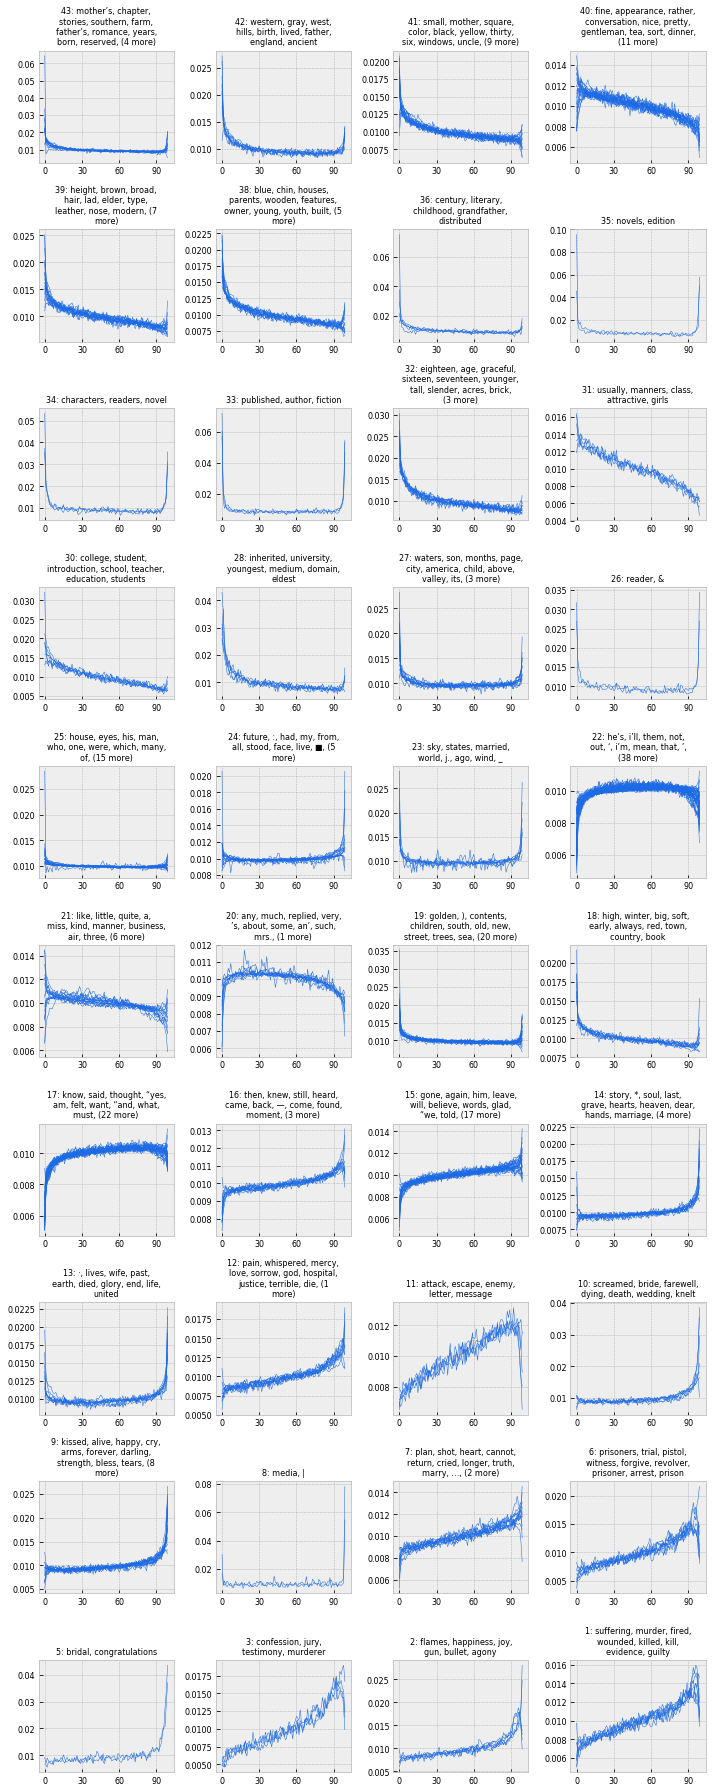

In [31]:
cohorts.plot_multiples()